In [ ]:
# make sure to install this package before running:
#!pip install sodapy
#!pip install scikit-learn
#!pip install statsmodels
#!pip install folium
#!pip install imblearn
#!pip install joblib
#!pip install geopandas

##if the libraries are not compatible, you might get an error --
#ensure compatible version of the two:
#!pip install -U scikit-learn imbalanced-learn

In [110]:
import pandas as pd
from sklearn.model_selection import train_test_split
import folium
from folium.plugins import HeatMap
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE

In [2]:
# Load the SF data
file_path = 'data/SF_Crime_Report_cleaned.csv'
data = pd.read_csv(file_path)

In [18]:
# Function to calculate the 'Hotspot' column
def calculate_hotspot(data):
    mean_30_days = data['Total_Incidents_All'].rolling(window=30).mean().shift(1)
    std_30_days = data['Total_Incidents_All'].rolling(window=30).std().shift(1)
    next_day_incidents = data['Total_Incidents_All'].shift(-1)
    hotspot = (next_day_incidents > (mean_30_days + std_30_days)).astype(int)
    return hotspot


In [19]:

data['Incident_Date'] = pd.to_datetime(data['Incident_Date'])

# Getting the unique police districts
districts = data['Police_District'].unique()

preprocessed_data = {}

for district in districts:
    print(f"Preprocessing data for Police District: {district}")
    data_district = data[data['Police_District'] == district].copy()

    # Aggregating incidents daily, counting the number of incidents of each type
    daily_totals = data_district.groupby('Incident_Date')['Incident_Category'].value_counts().unstack(fill_value=0)
    daily_totals['Total_Incidents_All'] = daily_totals.sum(axis=1)

    # Adding temporal and lag features
    daily_totals['Incident_Day_of_Week'] = daily_totals.index.dayofweek
    daily_totals['Month'] = daily_totals.index.month
    for lag in range(1, lags + 1):
        daily_totals[f'Incidents_Lag{lag}'] = daily_totals['Total_Incidents_All'].shift(lag)

    # Applying the function to calculate the 'Hotspot' column
    daily_totals['Hotspot'] = calculate_hotspot(daily_totals)
    daily_totals.dropna(inplace=True)

    # Store the preprocessed data
    preprocessed_data[district] = daily_totals


Preprocessing data for Police District: Central
Preprocessing data for Police District: Bayview
Preprocessing data for Police District: Northern
Preprocessing data for Police District: Southern
Preprocessing data for Police District: Mission
Preprocessing data for Police District: Richmond
Preprocessing data for Police District: Taraval
Preprocessing data for Police District: Park
Preprocessing data for Police District: Tenderloin
Preprocessing data for Police District: Ingleside
Preprocessing data for Police District: Out of SF


In [21]:
import joblib

trained_models = {}

for district, data_district in preprocessed_data.items():
    print(f"Training model for Police District: {district}")

    # Model training and evaluation
    X = data_district.drop(columns=['Hotspot'])
    y = data_district['Hotspot']

    # Handling class imbalance using SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

    # Random Forest with GridSearchCV
    param_grid_rf = {'n_estimators': [50, 100, 200, 500], 'max_depth': [None, 10, 20]}
    # Gradient Descent with GridSearchCV
    param_grid_gb = {'n_estimators': [50, 100, 200, 500], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 10]}
    

    # Random Forest and Gradient Boosting training
    rf_model = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, n_jobs=-1)
    gb_model = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gb, cv=5, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    gb_model.fit(X_train, y_train)

    # Save the models for this district
    trained_models[district] = {'RandomForest': rf_model.best_estimator_, 
                                'GradientBoosting': gb_model.best_estimator_,
                                'X_test': X_test,
                                'y_test': y_test}


Training model for Police District: Central
Training model for Police District: Bayview
Training model for Police District: Northern
Training model for Police District: Southern
Training model for Police District: Mission
Training model for Police District: Richmond
Training model for Police District: Taraval
Training model for Police District: Park
Training model for Police District: Tenderloin
Training model for Police District: Ingleside
Training model for Police District: Out of SF


In [23]:
#Save the models to disk for future use
for district, models in trained_models.items():
    joblib.dump(models['RandomForest'], f'models/rf_model_{district}.pkl')
    joblib.dump(models['GradientBoosting'], f'models/gb_model_{district}.pkl')
    

In [34]:
# # Load or preprocess the data
# X_test = X_test
# y_test = y_test


for district in districts:
    print(f"Predicting hotspots for Police District: {district}")

    # Load the test data for the district
    X_test = trained_models[district]['X_test']
    y_test = trained_models[district]['y_test']

    #Load trained model
    rf_model = joblib.load(f'models/rf_model_{district}.pkl')
    gb_model = joblib.load(f'models/gb_model_{district}.pkl')

    # Make predictions with the loaded models
    rf_predictions = trained_models[district]['RandomForest'].predict(X_test)
    gb_predictions = trained_models[district]['GradientBoosting'].predict(X_test)

    # Post-process predictions to identify hotspots
    rf_predictions = rf_model.predict(X_test)
    print("Random Forest Classifier:")
    print(f"Accuracy: {accuracy_score(y_test, rf_predictions)}")
    print("Classification Report:")
    print(classification_report(y_test, rf_predictions))

    gb_predictions = gb_model.predict(X_test)
    print("Gradient Boosting Classifier:")
    print(f"Accuracy: {accuracy_score(y_test, gb_predictions)}")
    print("Classification Report:")
    print(classification_report(y_test, gb_predictions))

Predicting hotspots for Police District: Central
Random Forest Classifier:
Accuracy: 0.9061624649859944
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       359
           1       0.93      0.87      0.90       355

    accuracy                           0.91       714
   macro avg       0.91      0.91      0.91       714
weighted avg       0.91      0.91      0.91       714

Gradient Boosting Classifier:
Accuracy: 0.9019607843137255
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       359
           1       0.90      0.90      0.90       355

    accuracy                           0.90       714
   macro avg       0.90      0.90      0.90       714
weighted avg       0.90      0.90      0.90       714

Predicting hotspots for Police District: Bayview
Random Forest Classifier:
Accuracy: 0.9046961325966851
Classification Report:
          

In [42]:
# Example new data row (ensure it's preprocessed correctly)
# just select 1 row of the X_test
#x_test_one_row = trained_models['Bayview']['X_test'].iloc[[0, ]]
#I can test with the y of that row
#y_print_one_row = trained_models['Bayview']['y_test'].iloc[[0, ]]

hotspot_predictions = {}

for district in districts:
    # Load the test data for the district
    X_test = trained_models[district]['X_test']
    
    # Select one row and convert to DataFrame with column names
    x_test_one_row = X_test.iloc[[0]].copy()

    model = trained_models[district]['RandomForest']  # or GradientBoosting
    # Make prediction using DataFrame
    prediction = model.predict(x_test_one_row)
    hotspot_predictions[district] = prediction[0]  # Binary prediction: 0 or 1


In [56]:
# Assuming hotspot_predictions is a dictionary with district names as keys
hotspot_predictions_capitalized =  {k.upper(): v for k, v in hotspot_predictions.items()}
hotspot_predictions_capitalized

{'CENTRAL': 0,
 'BAYVIEW': 1,
 'NORTHERN': 0,
 'SOUTHERN': 0,
 'MISSION': 1,
 'RICHMOND': 0,
 'TARAVAL': 1,
 'PARK': 1,
 'TENDERLOIN': 1,
 'INGLESIDE': 0,
 'OUT OF SF': 0}

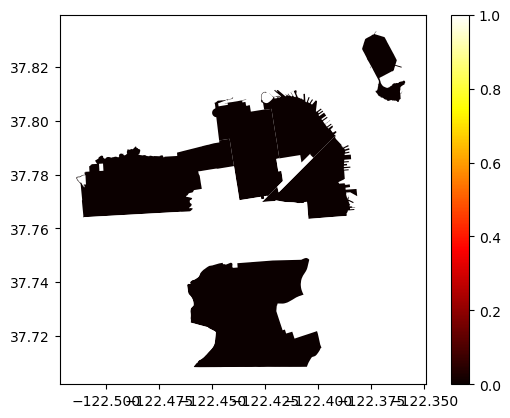

In [57]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the geographical boundaries
district_boundaries = gpd.read_file('data/Current_Police_Districts_GEOJSON.geojson')

# Map predictions to each district
district_boundaries['hotspot'] = district_boundaries['district'].map(hotspot_predictions_capitalized)

# Plot
fig, ax = plt.subplots(1, 1)
district_boundaries.plot(column='hotspot', ax=ax, legend=True, cmap='hot')
plt.show()


In [63]:
hotspot_predictions_capitalized

{'CENTRAL': 0,
 'BAYVIEW': 1,
 'NORTHERN': 0,
 'SOUTHERN': 0,
 'MISSION': 1,
 'RICHMOND': 0,
 'TARAVAL': 1,
 'PARK': 1,
 'TENDERLOIN': 1,
 'INGLESIDE': 0,
 'OUT OF SF': 0}

In [77]:
import geopandas as gpd

# Load GeoJSON file
gdf = gpd.read_file('data/Current_Police_Districts_GEOJSON.geojson')

# Check the current CRS
print(gdf.crs)

# If it's in a geographic CRS (like WGS84 - EPSG:4326), then project it to a suitable projected CRS
gdf = gdf.to_crs(epsg=4326)

# Now calculate the centroid
gdf['centroid'] = gdf['geometry'].centroid

# Extract the latitude and longitude of each centroid
gdf['centroid_lat'] = gdf['centroid'].y
gdf['centroid_lon'] = gdf['centroid'].x

# Add the predictions to the GeoDataFrame
gdf['prediction'] = gdf['district'].apply(lambda x: hotspot_predictions_capitalized[x])

# Create a list of [latitude, longitude, prediction] for the heatmap
heatmap_data = gdf[['centroid_lat', 'centroid_lon', 'prediction']].values.tolist()

# Initialize the map on San Francisco
map_sf = folium.Map(location=[37.7749, -122.4194], zoom_start=12)

# Add the heatmap to the map
HeatMap(heatmap_data).add_to(map_sf)

# Save to html
map_sf.save('sf_districts_heatmap.html')

EPSG:4326


/var/folders/l3/h56ll3s97r3bp825gbh1f4q80000gq/T/ipykernel_23353/2927178465.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf['geometry'].centroid


In [84]:
import folium
import geopandas as gpd

# Load GeoJSON file
gdf = gpd.read_file('data/Current_Police_Districts_GEOJSON.geojson')

# Ensure the GeoDataFrame is in the correct CRS
gdf = gdf.to_crs(epsg=4326)

# Add the predictions to the GeoDataFrame
gdf['prediction'] = gdf['district'].apply(lambda x: hotspot_predictions_capitalized.get(x.upper(), 0))

# Convert to JSON format
gdf_json = gdf.to_json()

# Initialize the map on San Francisco
map_sf = folium.Map(location=[37.7749, -122.4194], zoom_start=12)

# Function to color the district based on the prediction
def style_function(feature):
    return {
        'fillColor': 'red' if feature['properties']['prediction'] == 1 else 'green',
        'color': 'black',
        'weight': 1.5,
        'fillOpacity': 0.5,
    }

# Add the GeoJSON to the map with the style function
folium.GeoJson(
    gdf_json,
    style_function=style_function
).add_to(map_sf)

# Save to html
map_sf.save('sf_districts_colored_map.html')


In [109]:
import folium
from folium.plugins import HeatMap
import geopandas as gpd
from folium.features import GeoJsonTooltip

# Load GeoJSON file
gdf = gpd.read_file('data/Current_Police_Districts_GEOJSON.geojson')

# Project to EPSG:4326 if not already
gdf = gdf.to_crs(epsg=4326)

# Add prediction data to gdf for coloring
gdf['prediction'] = gdf['district'].apply(lambda x: hotspot_predictions_capitalized.get(x.upper(), 0))

# Initialize the map on San Francisco
map_sf = folium.Map(location=[37.7749, -122.4194], zoom_start=12)

# Function to convert prediction values to "Yes" or "No"
def prediction_text(value):
    return "Yes" if value == 1 else "No"

# Function to apply color based on prediction value
def style_function(feature):
    prediction_value = feature['properties']['prediction_text']
    return {
        'fillColor': 'red' if prediction_value == 'Yes' else 'green',
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.5,
    }

# Add the predictions as "Yes" or "No" to the GeoDataFrame for use in the tooltip
gdf['prediction_text'] = gdf['prediction'].apply(prediction_text)

# Update the tooltip fields to include 'prediction_text'
tooltip = GeoJsonTooltip(
    fields=['district', 'prediction_text'],
    aliases=['District:', 'Hotspot Prediction:'],
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #FFFFEF;
        opacity: 0.50;
        border: 1px solid black;
        border-radius: 3px;
    """,
    max_width=800,
)

# Make sure to use the updated 'gdf' with 'prediction_text' for the GeoJson
folium.GeoJson(
    gdf,
    style_function=style_function,
    tooltip=tooltip
).add_to(map_sf)

# Prepare heatmap data (using centroid for illustration)
heatmap_data = [
    [point.y, point.x, prediction] 
    for point, prediction in zip(gdf.centroid, gdf['prediction'])
    if prediction == 1  # assuming you only want to map hotspots
]

# Add heatmap layer on top of the colored districts
HeatMap(heatmap_data, min_opacity=0.5).add_to(map_sf)

# Save to HTML to view in a browser
map_sf.save('sf_districts_combined_map.html')


/var/folders/l3/h56ll3s97r3bp825gbh1f4q80000gq/T/ipykernel_23353/2568979887.py:61: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for point, prediction in zip(gdf.centroid, gdf['prediction'])
